Predictions from Bayesian modelling are probability distributions rather than point estimates, which reduces uncertainity and allows for a more interpretable model. It is a method of statistical inference, which allows use to combine prior information and knowledge about a parameter which evidence from knowledge gained from a data sample.

The aim is to determine the posterior distribution. This is the distribution representing our knowledge about a parameter or probability taking observed data into account. It is calculated by updating our prior knowledge about a system using Bayes Theorem.  

PyStan is the python interface to Stan, which performs Bayesian modelling. It uses a varient of Hamiltonian Monte Carlo which is a Markov chain monte carlo method.


Markov chain monto carlo is used to determine a distribution by randomly sampling values in a probabilistic space. ie we randomly generate samples, which influence new generated numbers, and we then accept or reject these based on some probabilistic rule. We then check when our data has converged to a reasonable distribution. At this point, our randomly generated values is our posterior distribution.


Firstly, a simple linear regression approach is taken to modelling of the penguins dataset (see the 'Penguin Project' file for the full code and notes for this approach).

PyStan is then used to model the problem with a Bayesian approach for comparison.



'The Bayesian approach treats the data as fixed and assesses the distribution of parameters that could have led to that data being seen' 

In [1]:
import pystan

In [2]:
# %load imports.py
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [4]:
penguins=sns.load_dataset('penguins').dropna(how='any', axis=0)
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


# 1. Linear Regression Model

(333,)
(333, 1)
y = 50.14 x1 - 5865.73 


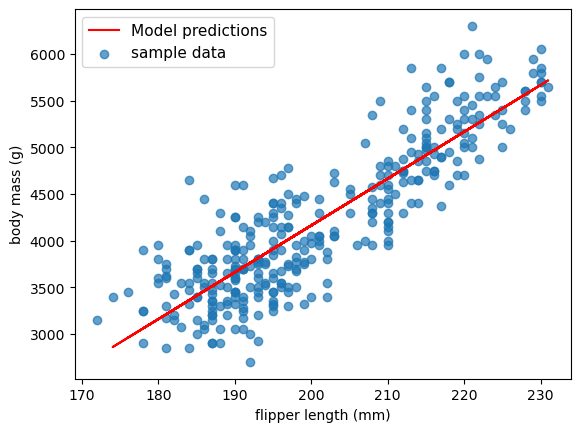

In [5]:


data=pd.concat([penguins['flipper_length_mm'],penguins['body_mass_g']], axis=1)

x=data['flipper_length_mm']
y=data['body_mass_g']

print(x.shape)

x=x.values.reshape(-1, 1)
y=y.values.reshape(-1, 1)

print(x.shape)

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)
regressor=LinearRegression()

model=regressor.fit(x_train,y_train)
predictions=model.predict(x_test)

print('y = %.2f x1 - %.2f ' % (model.coef_[0], abs(model.intercept_)))

%matplotlib inline
plt.style.use('default')
fig, ax = plt.subplots()
ax.plot(x_test, predictions, label= 'Model predictions', color='r')
ax.scatter(x,y, label= 'sample data', alpha=0.7)
ax.set_ylabel('body mass (g)')
ax.set_xlabel('flipper length (mm)')
ax.legend(facecolor='white', fontsize=11)

# 2. Bayesian Model

The first part of the model is written in stan. The stan model contains at least 3 blocks- data, parameter and model.

- data- here we specify the types and dimensions of data. N here is the number of data samples, x and y the vector inputs.

- parameters-  the intercept is alpha, gradient beta which are 'real. Sigma is gaussian noise. Here, the lower bound for sigma is 0 (the prior on sigma). 

- model- specifies the distribution statement, which here is a straight line with Gaussian noise.

In [6]:
sns.set()  # Nice plot aesthetic
np.random.seed(101)

model = """
data {
    int<lower=1> N;
    vector[N] x;
    vector[N] y;
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}
model {
    y ~ normal(alpha + beta * x, sigma);
}
"""

We need to transform the input data into PyStan format (a Python dictionary).

In [7]:
data=pd.concat([penguins['flipper_length_mm'],penguins['body_mass_g']], axis=1)

x=data['flipper_length_mm']
y=data['body_mass_g']

data_stan = {'N': len(x), 'x': x, 'y': y}

We could also intialize the variables alpha, beta and sigma prior to sampling, which allows us to specify some inital estimates.

In [8]:
alpha = -6000.0
beta =50
sigma =400

y = alpha + beta * x
y = np.random.normal(y, scale=sigma)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


We can use the data specified earlier to build the stan model. 

In [9]:
Stan_Model= pystan.StanModel(model_code=model)

# alternatively, we could have saved the model code in a file, and imported it here with 
# Stan_Model= pystan.StanModel(file="model.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_241b3d86feb06d35f6aa9943b883b992 NOW.


Initiate Monte Carlo sampling, where iter is the total number of samples that will be generated from each markov chain.

In [10]:
fit = Stan_Model.sampling(data=data_stan, iter=1000, seed=101)

In [11]:
stan_results = pd.DataFrame(fit.extract())
stan_describe=stan_results.describe()
print(stan_describe)

             alpha         beta        sigma         lp__
count  2000.000000  2000.000000  2000.000000  2000.000000
mean  -5879.903418    50.192024   394.841507 -2150.704801
std     320.551192     1.590970    16.565403     1.261442
min   -6984.347614    44.672775   336.243355 -2158.712681
25%   -6098.640429    49.105249   383.137370 -2151.304456
50%   -5879.301777    50.181282   393.714901 -2150.411911
75%   -5661.137939    51.270380   406.433412 -2149.793624
max   -4770.885972    55.642716   452.713713 -2149.099484


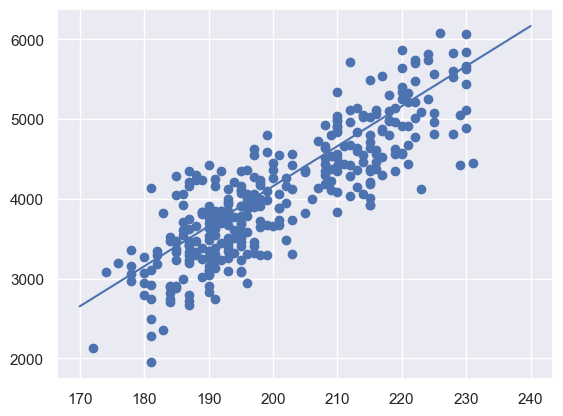

In [12]:
x_min, x_max = 170, 240
x_plot = np.linspace(x_min, x_max, 100)

stan_summary=fit.summary()

df = pd.DataFrame(stan_summary['summary'], 
                  columns=stan_summary['summary_colnames'], 
                  index=stan_summary['summary_rownames'])

alpha_mean, beta_mean = df['mean']['alpha'], df['mean']['beta']


plt.plot(x_plot, alpha_mean + beta_mean * x_plot)
plt.scatter(x, y)

Here we can see the value for alpha was estimated at -5879.9 and beta at 50.2, in comparison to the linear regression approach, which predicted these values to be -5865.73 and 50.1 respectively 

We can also plot posteriors, which wil give more insight into the sampling process. 

The sigma parameter represents the spread of the data.

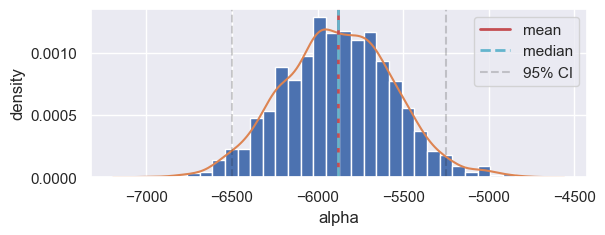

In [13]:
alpha=fit['alpha']

mean=np.mean(alpha)
median=np.median(alpha)
cred_min, cred_max = np.percentile(alpha, 2.5), np.percentile(alpha, 97.5)

plt.subplot(2,1,2)
plt.hist(alpha, 30, density=True)
sns.kdeplot(alpha)
plt.xlabel('alpha')
plt.ylabel('density')
plt.axvline(mean, color='r', lw=2, linestyle='-',label='mean')
plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
plt.axvline(cred_min, linestyle='--', color='k', alpha=0.2, label='95% CI')
plt.axvline(cred_max, linestyle='--', color='k', alpha=0.2)
plt.legend()

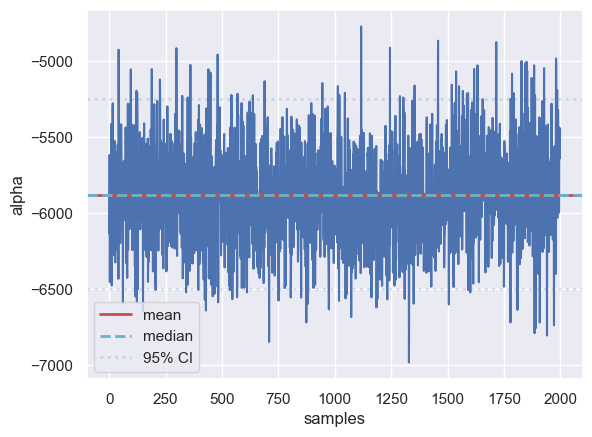

In [14]:
plt.plot(alpha)
plt.xlabel('samples')
plt.ylabel('alpha')
plt.axhline(mean, color='r', lw=2, linestyle='-', label='mean')
plt.axhline(median, color='c', lw=2, linestyle='--', label='median')
plt.axhline(cred_min, linestyle=':', lw=2, color='b', alpha=0.2, label='95% CI')
plt.axhline(cred_max, linestyle=':', lw=2, color='b', alpha=0.2)
plt.legend()

This shows us that the distributions are within the 95% intervals. There is some spread between the peaks of posteriors but we can improve the model by providing updated priors.